In [8]:
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.functions import *

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("DataProfiling").getOrCreate()

In [3]:
spark.conf.set("spark.executor.turnOff.jvmStackTrace", "true")

In [4]:
# Load the data into a DataFrame
df = spark.read.csv("sample_data.csv", header=True, inferSchema=True)
df.show(n=2)

+---+-----+----+-------+--------------+
| id| name| age| salary| date_of_birth|
+---+-----+----+-------+--------------+
|  1| John|32.0|50000.0|    1990-01-01|
|  2| Jane|28.0|45000.0|    1992-02-02|
+---+-----+----+-------+--------------+
only showing top 2 rows



In [19]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |--  name: string (nullable = true)
 |--  age: double (nullable = true)
 |--  salary: double (nullable = true)
 |--  date_of_birth: string (nullable = true)



In [24]:
total_rows = df.count()

profiling_data = {}
for i, col in enumerate(df.columns):
    # Repeated values
    expr = f"count > 1"
    repeated_count = df.groupBy(col).count().filter(expr).count()
    
    # Null values
    null_count = df.filter(isnull(col)).count()
    null_pct = (null_count / total_rows) * 100
    
    # Value types
    string_count = df.filter(df[col].cast("string").isNotNull()).count()
    int_count = df.filter(df[col].cast("integer").isNotNull()).count()
    float_count = df.filter(df[col].cast("float").isNotNull()).count()
    date_count = df.filter(to_date(df[col].cast("string")).isNotNull()).count()
    
    if int_count > 0:
        actual_data_type = "integer"
        deciding_factor = "majority"
    elif float_count > 0:
        actual_data_type = "float"
        deciding_factor = "majority"
    elif date_count > 0:
        actual_data_type = "date"
        deciding_factor = "majority"
    else:
        actual_data_type = "string"
        deciding_factor = "all string"
    
    
    original_data_type = df.dtypes[i][1]
    
    profiling_data[col] = {
        "repeated_count": repeated_count,
        "null_count": null_count,
        "null_pct": null_pct,
        "string_count": string_count,
        "int_count": int_count,
        "float_count": float_count,
        "date_count": date_count,
        "original_data_type" : original_data_type,
        "actual_data_type": actual_data_type,
        "deciding_factor": deciding_factor
    }
    
print(profiling_data)

{'id': {'repeated_count': 0, 'null_count': 0, 'null_pct': 0.0, 'string_count': 49, 'int_count': 49, 'float_count': 49, 'date_count': 0, 'original_data_type': 'int', 'actual_data_type': 'integer', 'deciding_factor': 'majority'}, ' name': {'repeated_count': 10, 'null_count': 0, 'null_pct': 0.0, 'string_count': 49, 'int_count': 0, 'float_count': 0, 'date_count': 0, 'original_data_type': 'string', 'actual_data_type': 'string', 'deciding_factor': 'all string'}, ' age': {'repeated_count': 10, 'null_count': 0, 'null_pct': 0.0, 'string_count': 49, 'int_count': 49, 'float_count': 49, 'date_count': 0, 'original_data_type': 'double', 'actual_data_type': 'integer', 'deciding_factor': 'majority'}, ' salary': {'repeated_count': 10, 'null_count': 0, 'null_pct': 0.0, 'string_count': 49, 'int_count': 49, 'float_count': 49, 'date_count': 0, 'original_data_type': 'double', 'actual_data_type': 'integer', 'deciding_factor': 'majority'}, ' date_of_birth': {'repeated_count': 10, 'null_count': 0, 'null_pct': 

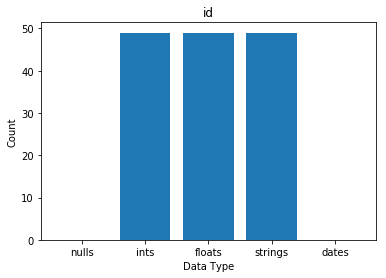

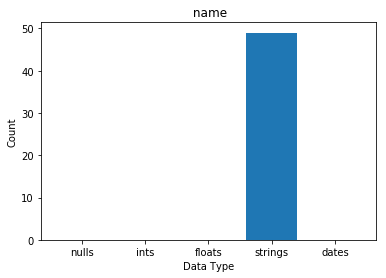

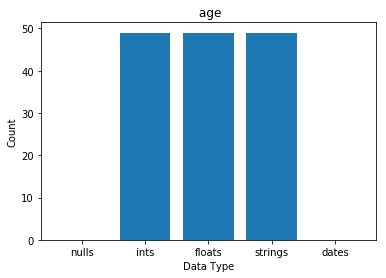

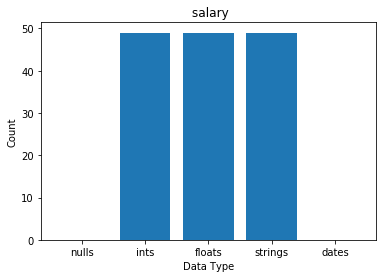

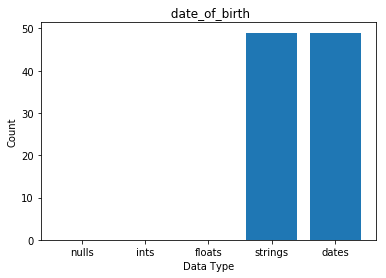

In [30]:
import matplotlib.pyplot as plt

def plot_col_stats(col, profiling_data):
    null_count = profiling_data[col]['null_count']
    int_count = profiling_data[col]['int_count']
    float_count = profiling_data[col]['float_count']
    string_count = profiling_data[col]['string_count']
    date_count = profiling_data[col]['date_count']
    
    fig, ax = plt.subplots()
    ax.bar(['nulls', 'ints', 'floats', 'strings', 'dates'], [null_count, int_count, float_count, string_count, date_count])
    ax.set_ylabel('Count')
    ax.set_xlabel('Data Type')
    ax.set_title(col)
    plt.show()

for col in df.columns:
    plot_col_stats(col, profiling_data)
